<h1>Содержание<span class="tocSkip"></span></h1><br>

<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель с предельно большим значением *F1*-меры (более 0.59).

## Подготовка данных

Для начала импортируем все необходимые библиотеки:

In [1]:
!pip install imblearn

     |████████████████████████████████| 226 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 66.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    roc_curve, 
    roc_auc_score
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

Прочитаем файл в переменную `data` и изучим данные:

In [3]:
if os.path.exists('Churn.csv'):
    data = pd.read_csv('Churn.csv')
elif os.path.exists('/datasets/Churn.csv'):
    data = pd.read_csv('/datasets/Churn.csv')
else:
    print("Проверьте правильность пути к датасету")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Первое, что бросается в глаза - пропуски в столбце Tenure. Рассмотрим их:

In [5]:
data.query('Tenure.isna()')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Вероятно, пропуски связаны с некорректными данными. Строки с пропусками цдалим из данных.

In [6]:
data = data.dropna(subset=['Tenure'])
data = data.reset_index(drop=True)

Столбцы `RowNumber`, `Surname`, `CustomerId` не влияют на уход клиентов, не являются признаками, удалим эти столбцы:

In [7]:
data = data.drop(['RowNumber','Surname', 'CustomerId'], axis=1);

Думаю, что страна влияет на отток клиетов, т.к. обслуживание в разных странах может отличаться. Этот признак мы оставим.

Разделим данные на три выборки: тренировочную, валидационную и тестовую:

In [9]:
target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)
print('Размер тренировочной выборки: ', features_train.shape[0])
print('Размер валидационной выборки: ', features_valid.shape[0])
print('Размер тестовой выборки: ', features_test.shape[0])

Размер тренировочной выборки:  5454
Размер валидационной выборки:  1818
Размер тестовой выборки:  1819


Масштабируем признаки. Отдельно будем масшабировать каждую из выборок методом `StandartScaler()`, для нашей задачи это не обязательно, т.к. мы будем использовать логистическую регрессию, решаюшее дерево и случайный лес:

Применим технику OHE из библиотеки `sklearn`:

In [10]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts', 'EstimatedSalary']
category = ['Geography','Gender']

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
encoder.fit(features_train[category])

encoder_train = pd.DataFrame(data=encoder.transform(features_train[category]), columns=encoder.get_feature_names_out())
features_train = features_train.drop(category, axis=1).reset_index(drop=True).join(encoder_train)

encoder_valid = pd.DataFrame(data=encoder.transform(features_valid[category]), columns=encoder.get_feature_names_out())
features_valid = features_valid.drop(category, axis=1).reset_index(drop=True).join(encoder_valid)

encoder_test = pd.DataFrame(data=encoder.transform(features_test[category]), columns=encoder.get_feature_names_out())
features_test = features_test.drop(category, axis=1).reset_index(drop=True).join(encoder_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Перед нами задача классификации, поэтому мы будем исследовать модели решающего дерева, случайного леса и логистической регрессии. 

Рассмотрим количество значений в целевом признаке:

In [12]:
data['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

Наблюдается явный дисбаланс классов: клиентов, которые не ушли гораздо больше, чем тех, которые ушли. Для начала проведем исследования без учета дисбаланса.

In [13]:
f1_global_not_balanced = []
roc_auc_global_not_balanced = []

Рассмотрим модель **решающего дерева**:

In [14]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Посчитаем точность - accuracy:

In [15]:
print(accuracy_score(target_valid, predictions_valid))

0.7904290429042904


Проверим также модель со всеми предсказаниями, равными 0:

In [16]:
predictions_valid_zero = [0]*len(target_valid)

In [17]:
print(accuracy_score(target_valid, predictions_valid_zero))

0.7926292629262927


Таким образом мы получаем практически одинаковую точность для моделей. Во-первых, выбранная метрика нам не подходит, а во-вторых, такие значения мы получаем из-за явного дисбаланса.

Рассчитаем сначала precision, recall, f1-меру и ROC-AUC для несбалансированных моделей, без изменения порога принятия решений:

Точность (precision)  0.4946524064171123
Полнота (recall)  0.4907161803713528
F1-мера (F1-score)  0.4926764314247669
ROC-AUC:  0.6797786314764468


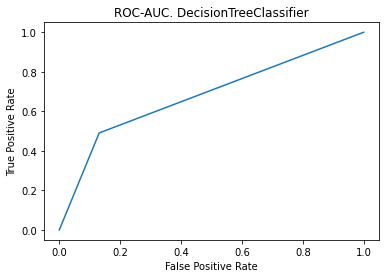

In [18]:
print('Точность (precision) ', precision_score(target_valid, predictions_valid))
print('Полнота (recall) ', recall_score(target_valid, predictions_valid))
print('F1-мера (F1-score) ', f1_score(target_valid, predictions_valid))
print('ROC-AUC: ', roc_auc_score(target_valid, probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. DecisionTreeClassifier');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

Первые три метрики примерно одинаковы. Метрика ROC-AUC больше, почти 0.7.

F1-мера не переходит метку в 0.59, такая модель точно нам не подходит, мы будем далее рассматривать модель решающего дерева с измененными гиперпараметрами.

Теперь рассмотрим модель **случайного леса**:

In [19]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Точность (precision)  0.7763157894736842
Полнота (recall)  0.46949602122015915
F1-мера (F1-score)  0.5851239669421487
ROC-AUC:  0.8629313566139046


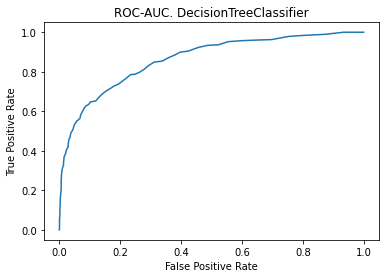

In [20]:
print('Точность (precision) ', precision_score(target_valid, predictions_valid))
print('Полнота (recall) ', recall_score(target_valid, predictions_valid))
print('F1-мера (F1-score) ', f1_score(target_valid, predictions_valid))
print('ROC-AUC: ', roc_auc_score(target_valid, probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. DecisionTreeClassifier');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

У модели случайного леса гораздо большая точность, нежели у предыдущей модели. F1-мера всё ещё не переходит границу в 0.59.

Кривая ROC-AUC также больше и кривая имеет иную форму (более кругулю).

Теперь рассмотрим модель **логистической регрессии**:

In [21]:
model = LogisticRegression(random_state=12345, max_iter=150)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Точность (precision)  0.6178861788617886
Полнота (recall)  0.20159151193633953
F1-мера (F1-score)  0.30400000000000005
ROC-AUC:  0.773663293800172


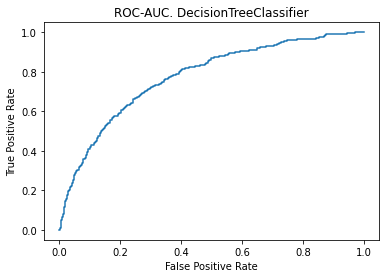

In [22]:
print('Точность (precision) ', precision_score(target_valid, predictions_valid))
print('Полнота (recall) ', recall_score(target_valid, predictions_valid))
print('F1-мера (F1-score) ', f1_score(target_valid, predictions_valid))
print('ROC-AUC: ', roc_auc_score(target_valid, probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. DecisionTreeClassifier');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

Кривая ROC-AUC движется к единице медленнее, чем в прошлом случае, о чем свидетельствует меньшая площадь под кривой.

Значение F1-меры у логистической регрессии без изменений совсем невелико, хотя метрика ROC-AUC не критично мала, а даже соответствует предыдущим получившимся значениям.

In [23]:
f1_global_not_balanced.append(f1_score(target_valid, predictions_valid))
roc_auc_global_not_balanced.append(roc_auc_score(target_valid, probabilities_one_valid))

Пока что параметры неидеальны. Т.к. перед нами стоит задача добиться наибольшей F1-меры, то мы ориентируемся на ее максимумы. Подберем наилучшую модель, изменяя гиперпараметры дерева решений и случайного леса. 

1. Изменение гиперпараметров дерева решений

In [24]:
f1_max = 0
roc_auc_true = 0
for depth in range(2, 100):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    predicted_valid = model_tree.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1_max:
        roc_auc_true = roc_auc_score(target_valid, probabilities_one_valid)
        depth_tree = depth
        f1_max = f1_score(target_valid, predicted_valid)

In [25]:
f1_global_not_balanced.append(f1_max)
roc_auc_global_not_balanced.append(roc_auc_true)
print('Глубина дерева:', depth_tree)

Глубина дерева: 7


Учитывая то, что наилучший результат у дерева мы получили при глубине 7, то для уменьшения времени подсчета, мы не будем брать слишком большой разброс параметров

In [26]:
f1_max = 0
for n_est in range (100, 200, 20):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model.fit(features_train, target_train)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

     
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > f1_max:
            depth_forest = depth
            f1_max = f1_score(target_valid, predicted_valid)
            n_est_forest = n_est 
            roc_auc_true = roc_auc_score(target_valid, probabilities_one_valid)

In [27]:
f1_global_not_balanced.append(f1_max)
roc_auc_global_not_balanced.append(roc_auc_true)
print('Глубина деревьев:', depth_forest, 'Количество деревьев:', n_est_forest) 

Глубина деревьев: 14 Количество деревьев: 120


Поясню, что я проверила также глубину до 30-ти - результат был таким же.

На валидационной выборке мы не получаем удовлетворительных результатов без применения методов балансирования.

В итоге мы получаем:

In [28]:
d = {'F1-measure': f1_global_not_balanced, 'ROC-AUC': roc_auc_global_not_balanced}
model_metrics = pd.DataFrame(data=d, index=['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'])
model_metrics

,F1-measure,ROC-AUC
LogisticRegression,0.304000,0.773663
DecisionTreeClassifier,0.576433,0.773663
RandomForestClassifier,0.589226,0.863372


- Результаты модели логистической регрессии наихудшие
- Параметр решаюшего дерева - глубина 7 - удовлетворительных результатов также не получаем
- Параметры случайного леса - глубина 14, кол-во деревьев 120 - с натяжкой можно сказать, что мы прошли порог F1-меры, но тем не менее, результаты не считаются удовлетворительными

**Вывод:**
Мы получили модель случайного леса, у которой F1-мера почти равна 0.59. В целом, нам не критически важна скорость (не нужно получать моментальный результат), поэтому предварительно я отдам предпочтение модели случайного леса. 

При увеличении F1-меры, также наблюдается увеличение и метрики ROC-AUC. Мы получили модели с оптимальными значениями полноты и точности.

## Борьба с дисбалансом

Применим несколько методов борьбы с дисбалансом.

Сздадим списки для записи полученных метрик.

**1. Изменение порога принятия решений**

In [29]:
metrics_threshold_change = []

Рассмотрим модель **решающего дерева**:

In [30]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Будем изменять порог приняти решений и посмотрим как это влияет на модель **решающего дерева**:

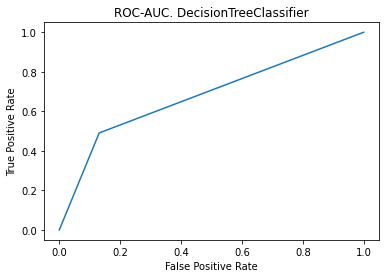

In [31]:
recall = []
precision = []
f1 = []
roc_auc = []
threshold = np.arange(0, 0.6, 0.05)

for t in threshold:
    predicted_valid = probabilities_one_valid > t
    precision.append(precision_score(target_valid, predicted_valid))
    recall.append(recall_score(target_valid, predicted_valid))
    f1.append(f1_score(target_valid, predicted_valid))
    roc_auc.append(roc_auc_score(target_valid, probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. DecisionTreeClassifier');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

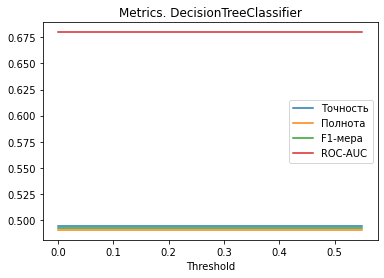

In [32]:
m = {'Порог' : threshold, 'Точность' : precision, 'Полнота' : recall, 'F1-мера' : f1, 'ROC-AUC': roc_auc}
metrics = pd.DataFrame(data=m)
metrics.plot(x='Порог');
plt.title('Metrics. DecisionTreeClassifier');
plt.xlabel('Threshold');

Изменение порога никак не влияет на результат у **решающего дерева**.

Результаты:

In [33]:
print('Полнота: ',  metrics['Полнота'].max())
print('Точность: ', metrics['Точность'].max())
print('F1-мера: ', metrics['F1-мера'].max())
print('ROC-AUC: ', metrics['ROC-AUC'].max())

Полнота:  0.4907161803713528
Точность:  0.4946524064171123
F1-мера:  0.4926764314247669
ROC-AUC:  0.6797786314764468


Сравнивая с "сырой" моделью:

In [34]:
model_metrics.loc['DecisionTreeClassifier']

F1-measure    0.576433
ROC-AUC       0.773663
Name: DecisionTreeClassifier, dtype: float64

Результат стал хуже, F1-мера не переходит метку в 0.59, такая модель точно нам не подходит.

Поэтому гипрепараметры менять смысла нет, запишем предыдущий результат.

In [35]:
metrics_threshold_change.append(model_metrics.loc['DecisionTreeClassifier', 'F1-measure'])

Теперь рассмотрим модель **случайного леса**:

In [36]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Здесь также будем менять порог принятия решений.

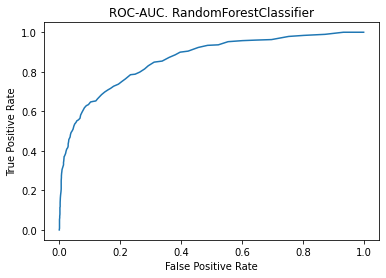

In [37]:
recall = []
precision = []
f1 = []
roc_auc = []
threshold = np.arange(0, 0.6, 0.05)

for t in threshold:
    predicted_valid = probabilities_one_valid > t
    precision.append(precision_score(target_valid, predicted_valid))
    recall.append(recall_score(target_valid, predicted_valid))
    f1.append(f1_score(target_valid, predicted_valid))
    roc_auc.append(roc_auc_score(target_valid, probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. RandomForestClassifier');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

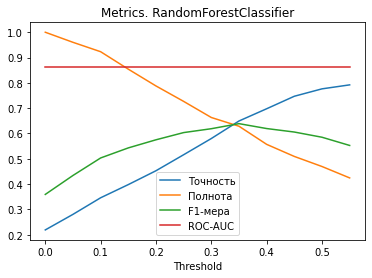

In [38]:
m = {'Порог' : threshold, 'Точность' : precision, 'Полнота' : recall, 'F1-мера' : f1, 'ROC-AUC': roc_auc}
metrics = pd.DataFrame(data=m)
metrics.plot(x='Порог')
plt.title('Metrics. RandomForestClassifier');
plt.xlabel('Threshold');

Анализируя изменение метрик в зависимости от порога, в общем, можно сказать, что метрика ROC-AUC постоянна с изменением порога. F1-мера возрастает до пересечения полноты и точности. Полнота уменьшается, что логично, поступает меньше положительных результатов, а точность увеличивается.

Выберем порог, при котором значение F1-меры максимально.

In [39]:
metrics[metrics['F1-мера'] == metrics['F1-мера'].max()]

,Порог,Точность,Полнота,F1-мера,ROC-AUC
7,0.35,0.649315,0.628647,0.638814,0.862931


По сравнению с небалансированной моделью:

In [40]:
model_metrics.loc['RandomForestClassifier']

F1-measure    0.589226
ROC-AUC       0.863372
Name: RandomForestClassifier, dtype: float64

Значение F1-меры нам подходит, оно больше, чем у несбалансируемой модели, а метрика ROC-AUC почти не изменилась.

Подберем оптимальные гиперпараметры для модели случайного леса с подобранным шагом.

In [41]:
f1_max = 0
for n_est in range (100, 200, 20):
    for depth in range(2, 15):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model_forest.fit(features_train, target_train)
        probabilities_valid = model_forest.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

        predicted_valid = probabilities_one_valid > 0.35
        if f1_score(target_valid, predicted_valid) > f1_max:
            depth_forest_th = depth
            f1_max = f1_score(target_valid, predicted_valid)
            roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
            n_est_forest_th = n_est 
print('Для модели случайного леса гиперапаметры: количество деревьев', n_est_forest_th, 'глубина', depth_forest_th)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели случайного леса гиперапаметры: количество деревьев 120 глубина 10
F1-мера: 0.6514285714285715 ROC-AUC: 0.8684876586956083


In [42]:
metrics_threshold_change.append(f1_max)

Теперь рассмотрим модель **логистической регрессии**:

In [43]:
model = LogisticRegression(random_state=12345, max_iter=150)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Будем менять порог принятия решений:

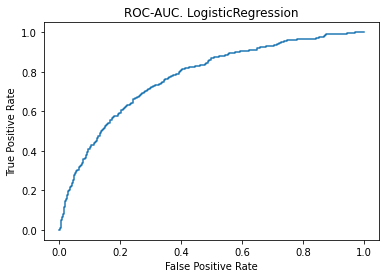

In [44]:
recall = []
precision = []
f1 = []
roc_auc = []
threshold = np.arange(0, 0.6, 0.05)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for t in threshold:
    predicted_valid = probabilities_one_valid > t
    precision.append(precision_score(target_valid, predicted_valid))
    recall.append(recall_score(target_valid, predicted_valid))
    f1.append(f1_score(target_valid, predicted_valid))
    roc_auc.append(roc_auc_score(target_valid,  probabilities_one_valid))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.plot(fpr, tpr);
plt.title('ROC-AUC. LogisticRegression');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

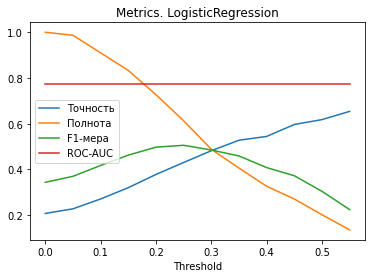

In [45]:
m = {'Порог' : threshold, 'Точность' : precision, 'Полнота' : recall, 'F1-мера' : f1, 'ROC-AUC': roc_auc}
metrics = pd.DataFrame(data=m)
metrics.plot(x='Порог')
plt.title('Metrics. LogisticRegression');
plt.xlabel('Threshold');

Поведение кривых аналогично предыдущей модели.

Оставим порог с наибольшим значением F1-меры:

In [46]:
metrics[metrics['F1-мера'] == metrics['F1-мера'].max()]

,Порог,Точность,Полнота,F1-мера,ROC-AUC
5,0.25,0.430168,0.612732,0.50547,0.773663


Значение ROC-AUC меньше, чем у других моделей, а F1-мера не проходит порог.

In [47]:
model_metrics.loc['LogisticRegression']

F1-measure    0.304000
ROC-AUC       0.773663
Name: LogisticRegression, dtype: float64

Однако, результат стал лучше, нежели чем у несбалансированной модели.

In [48]:
metrics_threshold_change.append(metrics['F1-мера'].max())

В результате наилучший результат показала модель случайного леса.

**2. Взвешивание классов**

Объектам редкого класса (класса 1) придадим больший вес параметром `class_weight`.

In [49]:
metrics_class_weighting = []

Рассмотрим модель **решающего дерева**:

In [50]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
    
print('Решающее дерево. Взвешивание классов')
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('ROC-AUC', roc_auc_score(target_valid, probabilities_one_valid))

Решающее дерево. Взвешивание классов
F1-мера: 0.46364883401920437
ROC-AUC 0.6606403599033238


F1-мера невелика. Будем **изменять гиперпараметры**.

In [51]:
f1_max = 0
for depth in range(2, 100):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    predicted_valid = model_tree.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1_max:
        depth_tree = depth
        f1_max = f1_score(target_valid, predicted_valid)
        roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
print('Для модели решающего дерева гиперапаметры: глубина', depth_tree)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели решающего дерева гиперапаметры: глубина 5
F1-мера: 0.5735449735449736 ROC-AUC: 0.6606403599033238


In [52]:
metrics_class_weighting.append(f1_max)

Результат стал лучше.

Перейдем к модели **случайного леса**:

In [53]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Случайный лес. Взвешивание классов')
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('ROC-AUC', roc_auc_score(target_valid, probabilities_one_valid))

Случайный лес. Взвешивание классов
F1-мера: 0.5564924114671164
ROC-AUC 0.8628604877617776


Будем **менять гиперпараметры**.

In [54]:
f1_max = 0
for n_est in range (100, 200, 20):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > f1_max:
            depth_forest = depth
            f1_max = f1_score(target_valid, predicted_valid)
            roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
            n_est_forest = n_est 
print('Для модели случайного леса гиперапаметры: количество деревьев', n_est_forest, 'глубина', depth_forest)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели случайного леса гиперапаметры: количество деревьев 140 глубина 9
F1-мера: 0.6498740554156172 ROC-AUC: 0.8628604877617776


In [55]:
metrics_class_weighting.append(f1_max)

Модель **логистической регрессии**:

In [56]:
model = LogisticRegression(random_state=12345, max_iter=150, class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Логистическая регрессия. Взвешивание классов')
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('ROC-AUC', roc_auc_score(target_valid, probabilities_one_valid))

Логистическая регрессия. Взвешивание классов
F1-мера: 0.509731232622799
ROC-AUC 0.7777792094717602


In [57]:
metrics_class_weighting.append(f1_score(target_valid, predicted_valid))

Итог:
- наибольшие значения метрик всё еще у случайного леса, только эта модель пока что проходит порог
- пока что взвешивание класса оптимальный метод балансирования по сравнению с предыдущем для моделей случайного леса и логистической регрессии
- у решающего дерева в данном случае метрики стали хуже

**3. Увеличение выборки**

Попробуем увеличить выборку и посмотрим на результат и F1-меру.

In [58]:
metrics_upsample = []

Применим фунцию `SMOTE()`, создадим новые тестовые выборки:

In [60]:
smote = SMOTE(random_state=12345)
features_upsampled, target_upsampled = smote.fit_resample(features_train, target_train)

Рассмотрим модель **решающего дерева**:

Изменим гиперпараметры:

In [61]:
f1_max = 0
for depth in range(2, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    if f1_score(target_valid, predicted_valid) > f1_max:
        depth_tree = depth
        f1_max = f1_score(target_valid, predicted_valid)
        roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
print('Для модели решающего дерева гиперапаметры: глубина', depth_tree,'F1-мера')
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели решающего дерева гиперапаметры: глубина 5 F1-мера
F1-мера: 0.5755555555555556 ROC-AUC: 0.8391046963039592


In [62]:
metrics_upsample.append(f1_max)

Тем не менее, порог F1-меры всё равно не преодолен.

**Случайный лес**:

In [63]:
f1_max = 0
for n_est in range (100, 200, 20):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model.fit(features_upsampled, target_upsampled)
        
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        if f1_score(target_valid, predicted_valid) > f1_max:
            depth_forest = depth
            f1_max = f1_score(target_valid, predicted_valid)
            roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
            n_est_forest = n_est 
print('Для модели случайного леса гиперапаметры: количество деревьев', n_est_forest, 'глубина', depth_forest)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели случайного леса гиперапаметры: количество деревьев 100 глубина 11
F1-мера: 0.646074646074646 ROC-AUC: 0.8670297851661368


In [64]:
metrics_upsample.append(f1_max)

**Логистическая регрессия**:

In [65]:
f1_max = 0
model = LogisticRegression(random_state=12345, max_iter=300)
model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
    
f1_max = f1_score(target_valid, predicted_valid)
roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
print('Для модели логистической регрессии')
print('F1-мера:', f1_max)
print('ROC-AUC:', roc_auc_max)       

Для модели логистической регрессии
F1-мера: 0.5
ROC-AUC: 0.7712371860831984


In [66]:
metrics_upsample.append(f1_max)

Порог F1-меры также не преодолен.

Все метрики у каждой модели получились хуже, чем в предыдущих случаях.

**4. Уменьшение выборки**

In [67]:
metrics_downsample = []

Применим фунцию `RandomUnderSampler()`, создадим новые тестовые выборки:

In [69]:
rus = RandomUnderSampler(random_state=12345)
features_downsampled, target_downsampled = rus.fit_resample(features_train, target_train)

**Модель решающего дерева:**

Изменим гиперпараметры:

In [70]:
f1_max = 0
for depth in range(2, 100):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > f1_max:
        depth_tree = depth
        f1_max = f1_score(target_valid, predicted_valid)
        roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
print('Для модели решающего дерева гиперапаметры: глубина', depth_tree)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели решающего дерева гиперапаметры: глубина 8
F1-мера: 0.5694022289766971 ROC-AUC: 0.8060024997376932


In [71]:
metrics_downsample.append(f1_max)

**Модель случайного леса**:  

Изменим гиперпараметры.

In [72]:
f1_max = 0
for n_est in range (100, 200, 20):
    for depth in range(2, 15):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model.fit(features_downsampled, target_downsampled)
        
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        if f1_score(target_valid, predicted_valid) > f1_max:
            depth_forest = depth
            f1_max = f1_score(target_valid, predicted_valid)
            roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
            n_est_forest = n_est 
print('Для модели случайного леса гиперапаметры: количество деревьев', n_est_forest, 'глубина', depth_forest)
print('F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для модели случайного леса гиперапаметры: количество деревьев 160 глубина 9
F1-мера: 0.6028225806451613 ROC-AUC: 0.8691263987394547


In [73]:
metrics_downsample.append(f1_max)

In [74]:
f1_max = 0
model = LogisticRegression(random_state=12345, max_iter=150)
model.fit(features_downsampled, target_downsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = model.predict(features_valid)

f1_max = f1_score(target_valid, predicted_valid)
roc_auc_max = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Для логистической регрессии F1-мера:', f1_max, 'ROC-AUC:', roc_auc_max)

Для логистической регрессии F1-мера: 0.502283105022831 ROC-AUC: 0.775631054915077


In [75]:
metrics_downsample.append(f1_max)

Итак:
- снова только модель случайного леса переходит границу F1-меры
- логистическая регрессия дает лучший результат для сбалансированный моделей

In [76]:
metrics_final = {'Без баланса': f1_global_not_balanced, 'Изменение порога': metrics_threshold_change,
                 'Взвешивание классов': metrics_class_weighting, 
                 'Увеличение выборки': metrics_upsample,'Уменьшение выборки':metrics_downsample}
index = ['Решающее дерево', 'Случайный лес', 'Логистическая регрессия']
summary = pd.DataFrame(data=metrics_final,index=index)
summary.style.highlight_max(color = 'lightgreen', axis = 1)

,Без баланса,Изменение порога,Взвешивание классов,Увеличение выборки,Уменьшение выборки
Решающее дерево,0.304000,0.576433,0.573545,0.575556,0.569402
Случайный лес,0.576433,0.651429,0.649874,0.646075,0.602823
Логистическая регрессия,0.589226,0.505470,0.509731,0.500000,0.502283


In [77]:
print('Наилучшая модель - модель случайного леса при изменении порога принятия решений до 0.35 с гиперпараметрами')
print(f'Глубина: {depth_forest_th}, количество деревьев: {n_est_forest_th}')

Наилучшая модель - модель случайного леса при изменении порога принятия решений до 0.35 с гиперпараметрами
Глубина: 10, количество деревьев: 120


## Тестирование модели

Проверим показатели модели также на тестовой выборке:

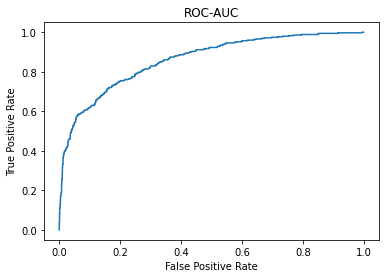

In [78]:
probabilities_test_forest = model_forest.predict_proba(features_test)
probabilities_one_test_forest = probabilities_test_forest[:, 1]

predicted_test = probabilities_one_test_forest > 0.35

fpr_forest, tpr_forest, thresholds = roc_curve(target_test, probabilities_one_test_forest) 
plt.plot(fpr_forest, tpr_forest);
plt.title('ROC-AUC');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

In [79]:
f1_final = f1_score(target_test, predicted_test)
roc_auc_final = roc_auc_score(target_test, predicted_test)
print('Значение F1-меры: ', f1_final)
print('Значение ROC-AUC: ', roc_auc_final)

Значение F1-меры:  0.6101694915254237
Значение ROC-AUC:  0.7596677845315448


Кривая ROC-AUC далека от случайной кривой, соотношение долей ложноположительных и истинно положительных ответов свидетельствует о качестве модели. Площадь под получившейся кривой близка к 0.8, что также свидетельствует о высоком качестве полученной модели.

F1-мера получилась меньше, чем при тестах на валидационной выоборке, что логично, но всё ещё выше 0.59.

## Выводы

Были исследованы три модели: логистическая регрессия, решающее дерево и случайный лес.


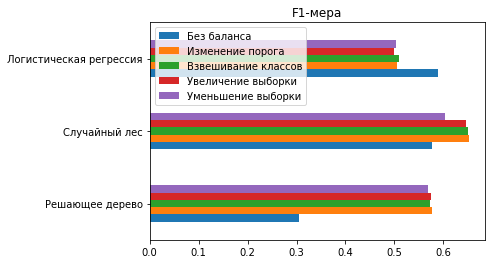

In [80]:
summary.plot(kind='barh')
plt.title('F1-мера');
plt.legend(loc='upper left');

Мы получили:
- наиболее лучшие показатели практически всегда получались у модели случайного леса, что логично, т.к. она дает наилучшие результаты в силу своей архитектуры
- логистическая регрессия дает лучший результат без учета дисбаланса, а другие модели показывают наилучшие показатели с учетом дисбаланса
- самый эффективный метод борьба с дисбалансом для случайного леса - изменение порога принятия решений, как и для решающего дерева
- при взвешивании классов метрики моделей также показывает неплохие результаты

In [81]:
print('Итоговая модель - модель случайного леса при изменении порога принятия решений до 0.35 с гиперпараметрами')
print(f'Глубина: {depth_forest_th}, количество деревьев: {n_est_forest_th}')
print(f'F1-мера для тестовой выборки: {f1_final:.2f} ROC-AUC для тестовой выборки: {roc_auc_final:.2f}')

Итоговая модель - модель случайного леса при изменении порога принятия решений до 0.35 с гиперпараметрами
Глубина: 10, количество деревьев: 120
F1-мера для тестовой выборки: 0.61 ROC-AUC для тестовой выборки: 0.76
